**Juan José Triviño Zambrano**  
**Abril 10, 2021**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import pandas_datareader as pdr
from yahoo_fin import stock_info as si
from scipy.stats import shapiro
from yahoofinancials import *

In [2]:
def preparar_datos(datos):
    
    # Lo primero es seleccionar las columnas que contienen los datos que nos interesan
    d = pd.read_csv(datos, index_col=0, usecols=[0,2,6]).dropna()
    # 
    d['firstTradeDate'] = d['firstTradeDate'].apply(lambda x: eval(x))
    d['prices'] = d['prices'].apply(lambda x: eval(x))
    #Extrae desde los objetos que están en la columna firstTradeDate solo el datos que nos interesa que es: 'formatted_date'
    d['firstTradeDate'] = d['firstTradeDate'].apply(lambda x: x['formatted_date'])
    #Crea una columna cuyos valores serán diccionarios compuestos de las fechas como clave y los precios como valor
    d['adjclose'] = d['prices'].apply(lambda x: {item['formatted_date']:item['adjclose'] for item in x})
    #d = d[d['firstTradeDate']<ini]
    #Crea una columna para cada fecha contenida en 'adjclose' donde sus valores serán sus precios respectivos
    fechas = list(d['adjclose'][0].keys())
    for fecha in fechas:
        d[fecha] = d.adjclose.apply(lambda x: x[fecha] if fecha in x else np.nan)
    # una vez extraído y separado en columnas los datos relevantes que vamos a analizar, descartamos las columnas procesadas
    data = d.T.drop(['firstTradeDate', 'prices', 'adjclose'])
    data.index.name = 'Fecha'
    return data, d.firstTradeDate

def calcular_acciones(data, base, ini, med, med2, fin):
    
    # seleccionamos el rango de fechas a analizar por defecto todo el rango
    data1 = data[ini:med]
    # Haciendo los cálculos de retornos, volatilidades y ratio sharpe
    rets = data1/data1.shift(1)-1
    r_anual = rets.mean()*252
    v_anual = rets.std()*np.sqrt(252)
    sharpe = r_anual/v_anual
    feb20 = data1.loc[med]
    pmax = data1.max()
    # Formando un DataFrame con los resultados
    pd.options.display.float_format = '{:,.2f}'.format
    df = pd.DataFrame([r_anual, sharpe, feb20, pmax],['$\mu$', 'Sharpe', 'feb20', 'pmax'])
    df.loc['Sharpe'] = df.loc['Sharpe'].map('{:.5f}'.format).astype(float)
    df = df.T
    df.index.name = 'Symbol'
    
    # seleccionamos el rango de fechas a analizar por defecto todo el rango
    data2 = data[med2:fin]
    # Haciendo los cálculos de retornos, volatilidades y ratio sharpe
    rets2 = data2/data2.shift(1)-1
    r_anual2 = rets2.mean()*252
    v_anual2 = rets2.std()*np.sqrt(252)
    sharpe2 = r_anual2/v_anual2
    pmax2 = data2.max()
    pmin2 = data2.min()
    sd = data2.std()

    # Formando un DataFrame con los resultados
    #pd.options.display.float_format = '{:,.2f}'.format
    df2 = pd.DataFrame([r_anual2, sharpe2, sd, pmin2, pmax2],['$\mu_2$', 'Sharpe2', 'sd', 'pmin2', 'pmax2'])
    df2.loc['Sharpe2'] = df2.loc['Sharpe2'].map('{:.5f}'.format).astype(float)
    df2 = df2.T
    df2.index.name = 'Symbol' 
    
    
    # Cargando el archivo con la información base
    base = pd.read_csv(base)
    base.rename(index=str, columns={"Market Cap": "MarketCap", "Div Yield":"Div", "EPS ttm": "BPA", "P/E (ttm)": "PER",
                                    "Price/Book": "P/B", "ROE%": "ROE", "ROA%": "ROA", "Debt/Equity": "D/E"}, inplace=True)
    base['MarketCap'] = (base['MarketCap'] / 10**6)
    #df2.loc['$Sharpe$'] = df2.loc['$Sharpe$']
    # Uniendo los 2 DataFrames
    full = pd.merge(df, df2, on='Symbol')
    full = pd.merge(full, base, on='Symbol')
    #Ordenando los datos en función del ratio Sharpe en forma descendente
    full.sort_values('Sharpe2', ascending=False, inplace=True)
    
    full.set_index('Symbol', inplace=True)
    
    
    return full

## Cargando los datos

In [3]:
#Precios
precios = pd.read_excel('prices.xlsx', index_col=0)

#Fecha de inicio en bolsa
firstTrade =  pd.read_excel('first_trade.xlsx')
firstTrade.firstTradeDate = firstTrade.firstTradeDate.astype('datetime64')

#Datos fundamentales y descriptivos
base = 'full.csv'

# Consultas de escenarios

#### Configuración

In [4]:
ini = '2017-02-01'
med = '2020-02-20' # Inicio de la debacle en bolsa
med2 = '2020-03-23' # Fin de la debacle en bolsa
fin = date.today().strftime('%Y-%m-%d')


df = calcular_acciones(precios, base, ini, med, med2, fin)
df = pd.merge(df, firstTrade, on='Symbol').set_index('Symbol')

### Acciones que todavia no recuperan su maximo nivel de antes de la pandemia

In [5]:
#### Filtro
df[(df['Sharpe']>1.0) & (df['pmax2']/df['feb20']<0.5)]

,$\mu$,Sharpe,feb20,pmax,$\mu_2$,Sharpe2,sd,pmin2,pmax2,Name,...,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,,,,,,,
ACR,0.20,1.07,37.44,37.44,1.50,1.04,3.07,3.18,16.15,Acres Commercial Realty Corp,...,148.34,0.00,1.93,8.20,0.48,0.08,0.01,3.90,-392.98,2006-02-07
IVR,0.20,1.37,15.07,15.07,0.86,0.60,0.59,1.79,6.44,Invesco Mortgage Capital Inc,...,914.16,0.08,-1.15,0.00,1.03,-0.21,-0.02,0.00,-597.62,2009-07-01
WMC,0.17,1.06,10.62,10.62,0.52,0.49,0.53,1.36,3.78,Western Asset Mortgage Capital,...,194.60,0.07,0.62,5.16,0.76,0.16,0.01,11.66,209.88,2012-05-11


### Acciones 'Blue Chips' con desempeño sobresaliente el último año

In [6]:
df[df['MarketCap']>100000].sort_values('Sharpe2', ascending=False).iloc[:20]

,$\mu$,Sharpe,feb20,pmax,$\mu_2$,Sharpe2,sd,pmin2,pmax2,Name,...,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,,,,,,,
DE,0.20,0.76,162.63,175.57,1.26,3.32,74.77,109.00,379.48,Deere & Company,...,"117,000.00",0.01,10.94,34.26,8.34,0.27,0.05,2.53,7.74,1972-06-01
LOW,0.24,0.92,124.49,124.49,1.11,3.12,27.55,66.69,198.51,Lowe's Companies,...,"139,000.00",0.01,8.83,21.93,98.78,2.30,0.14,5.20,6.51,1980-03-17
SQ,0.70,1.49,85.70,99.01,2.01,3.06,64.03,40.01,276.57,Square,...,"117,000.00",0.00,0.00,0.00,39.12,0.01,0.00,0.96,2.24,2015-11-19
TSLA,0.56,1.06,179.88,183.48,2.26,2.92,232.63,86.86,883.09,Tesla Inc,...,"656,000.00",0.00,0.63,"1,071.84",28.39,0.05,0.02,0.42,2.19,2010-06-29
MS,0.13,0.53,52.25,55.55,1.14,2.61,14.52,27.04,84.34,Morgan Stanley,...,"150,000.00",0.02,6.54,12.09,1.51,0.13,0.01,2.31,22.81,1993-02-23
AVGO,0.22,0.72,293.44,308.11,0.98,2.60,77.14,186.70,488.48,Broadcom Ltd,...,"198,000.00",0.03,20.08,24.03,8.32,0.38,0.12,1.69,12.39,2009-08-06
AMAT,0.29,0.82,65.60,66.60,1.33,2.59,25.02,39.68,143.05,Applied Materials,...,"128,000.00",0.01,4.59,30.31,11.44,0.42,0.19,0.52,21.04,1980-03-17
CAT,0.18,0.67,133.15,157.68,0.98,2.57,37.44,89.31,233.71,Caterpillar Inc,...,"126,000.00",0.02,6.09,37.83,8.29,0.23,0.04,1.69,7.18,1962-01-02
FERG,0.17,0.92,NaN,"5,871.52",0.85,2.53,13.56,91.69,127.22,Ferguson Plc,...,"286,000.00",0.01,0.00,0.00,65.45,0.00,0.00,NaN,4.40,2010-01-05


### Acciones con buena tendencia antes y después de la debacle en bolsa

In [7]:
df[(df['Sharpe']>1.0) & (df['Sharpe2']>1.5) & (df['PER'].apply(lambda x: (x>5) & (x<30))) & (df['MarketCap']>500)]

,$\mu$,Sharpe,feb20,pmax,$\mu_2$,Sharpe2,sd,pmin2,pmax2,Name,...,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,,,,,,,
RCII,0.44,1.08,24.54,29.69,1.71,2.96,12.68,11.52,63.91,Rent-A-Center Inc,...,"3,145.13",0.02,3.54,16.30,5.30,0.38,0.12,0.32,7.40,1995-01-25
ONEW,5.83,6.61,18.00,18.00,2.37,2.90,9.52,5.02,44.10,Onewater Marine Inc Cl A,...,648.12,0.00,4.15,9.97,3.39,0.18,0.06,0.60,1.70,2020-02-07
CROX,0.64,1.39,36.90,43.40,2.04,2.84,20.22,12.54,84.80,Crocs Inc,...,"5,305.88",0.00,3.23,25.30,18.61,1.15,0.25,0.62,22.57,2006-02-08
LPLA,0.36,1.28,97.26,97.31,1.33,2.76,26.13,41.06,146.52,Lpl Financial Hld,...,"11,663.00",0.01,6.45,22.38,8.75,0.45,0.08,1.78,8.05,2010-11-18
TSLX,0.18,1.37,18.96,18.96,0.87,2.72,2.76,9.43,22.21,Tpg Specialty Lending Inc,...,"1,502.54",0.08,2.21,9.97,1.26,0.13,0.07,0.96,54.44,2014-03-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WLTW,0.20,1.11,205.90,216.28,0.54,1.54,15.65,145.03,239.98,Willis Towers WT,...,"30,575.39",0.01,11.70,20.33,2.78,0.14,0.04,0.43,10.65,2001-06-12
PGR,0.31,1.49,76.72,79.58,0.44,1.53,7.97,63.16,96.62,Progressive Corp,...,"55,577.84",0.05,7.45,12.87,3.42,0.27,0.07,0.33,13.37,1980-03-17
CCMP,0.35,1.12,161.00,164.43,0.91,1.51,19.11,90.11,196.90,Cabot Microelectron,...,"5,733.94",0.01,7.43,26.35,5.14,0.21,0.09,0.82,12.80,2000-04-05


### Acciones con buen crecimiento y con un PER razonable

In [8]:
df[(df['Sharpe2'] > 2) & (df['PER'].apply(lambda x: (x>5) & (x<25)))][:10]

,$\mu$,Sharpe,feb20,pmax,$\mu_2$,Sharpe2,sd,pmin2,pmax2,Name,...,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,,,,,,,
DAC,-0.21,-0.26,6.72,42.00,3.27,3.60,15.24,2.83,56.63,Danaos Corp,...,"1,158.03",0.00,7.25,7.39,1.04,0.18,0.06,1.24,33.27,2006-10-16
HIBB,0.07,0.12,23.57,33.45,2.37,3.29,18.51,7.94,76.04,Hibbett Sports Inc,...,"1,180.28",0.00,6.11,11.29,3.04,0.29,0.13,0.01,5.23,1996-10-11
RILY,0.22,0.66,23.96,25.98,1.58,3.28,14.12,13.22,62.31,B. Riley Financl,...,"1,631.19",0.03,8.72,6.89,2.92,0.60,0.10,3.20,22.73,2007-08-13
AVNW,0.11,0.26,6.70,11.77,2.60,3.28,9.21,3.70,41.97,Aviat Networks Inc,...,450.68,0.00,3.86,21.60,5.49,0.29,0.12,0.00,0.11,1987-05-19
TFII,0.15,0.56,35.01,35.50,1.56,3.15,16.03,16.73,79.77,Tfi International Inc,...,"7,164.38",0.01,3.30,23.00,3.96,0.19,0.08,0.46,7.29,2005-11-15
LOW,0.24,0.92,124.49,124.49,1.11,3.12,27.55,66.69,198.51,Lowe's Companies,...,"139,000.00",0.01,8.83,21.93,98.78,2.30,0.14,5.20,6.51,1980-03-17
TX,0.06,0.18,18.86,35.95,1.46,3.06,8.16,9.43,39.93,Ternium S.A.,...,"7,802.45",0.03,3.72,10.59,0.93,0.09,0.06,0.19,8.91,2006-02-01
WSM,0.23,0.69,72.37,74.29,1.70,3.03,31.33,36.37,186.89,Williams-Sonoma,...,"14,119.33",0.01,9.05,19.74,8.48,0.51,0.16,0.21,10.04,1983-07-07
LAD,0.15,0.44,129.87,162.22,1.85,3.02,96.50,66.70,414.12,Lithia Motors,...,"10,488.21",0.00,18.08,21.45,3.90,0.24,0.07,0.78,3.58,1996-12-18


## Funciones para categorizar empresas y compararlas

In [9]:
def categorias(ticker, df):
    cia = df.loc[ticker]
    
    if cia['SIC Description'] in df['SIC Description'].dropna().values:
        return pd.DataFrame({'Nombre de Categoria':[cia['Sector'], cia['Industry'], cia['SIC Description']], 
                  'Cantidad':[df.groupby('Sector').size()[cia['Sector']], 
                              df.groupby('Industry').size()[cia['Industry']], 
                              df.groupby('SIC Description').size()[cia['SIC Description']]]},
                  index = ['Sector', 'Industria', 'SIC'])
    else:
        return pd.DataFrame({'Nombre de Categoria':[cia['Sector'], cia['Industry'], 'ND'], 
                  'Cantidad':[df.groupby('Sector').size()[cia['Sector']], 
                              df.groupby('Industry').size()[cia['Industry']], 
                              'ND']},
                  index = ['Sector', 'Industria', 'SIC'])
        
        

def comparar_empresa(ticker, df):
    cia = df.loc[ticker]
    if cia['SIC Description'] in df['SIC Description'].dropna().values:
            sector = df.groupby('Sector').mean().loc[cia['Sector']]
            industria = df.groupby('Industry').mean().loc[cia['Industry']]
            sic = df.groupby('SIC Description').mean().loc[cia['SIC Description']]
            df = pd.DataFrame([cia, sector, industria, sic])
            return df.iloc[:,[0,1,3,4,7,9,12,13,14,15,16,17,18,19,20]]
    else:
        sector = df.groupby('Sector').mean().loc[cia['Sector']]
        industria = df.groupby('Industry').mean().loc[cia['Industry']]
        df = pd.DataFrame([cia, sector, industria])
        return df.iloc[:,[0,1,3,4,7,9,12,13,14,15,16,17,18,19,20]]
        

In [10]:
ticker = 'AMD'
categorias(ticker, df)

,Nombre de Categoria,Cantidad
Sector,Computers and Technology,544
Industria,Electronics - Semiconductors,32
SIC,SIC-3674 Semiconductors & Related Devices,57


In [11]:
comparar_empresa(ticker, df)

,$\mu$,Sharpe,pmax,$\mu_2$,pmin2,Name,SIC Description,Sector,MarketCap,Div,BPA,PER,P/B,ROE,ROA
AMD,0.68,1.18,58.90,0.79,41.64,Adv Micro Devices,SIC-3674 Semiconductors & Related Devices,Computers and Technology,"101,000.00",0.00,1.07,76.82,16.90,0.33,0.18
Computers and Technology,0.19,0.49,70.37,1.06,36.51,NaN,NaN,NaN,"30,367.26",0.00,1.60,70.98,13.29,0.06,0.01
Electronics - Semiconductors,0.19,0.40,48.17,1.19,21.47,NaN,NaN,NaN,"12,475.66",0.00,1.27,86.99,6.00,0.02,-0.01
SIC-3674 Semiconductors & Related Devices,0.31,0.47,55.30,1.54,25.12,NaN,NaN,NaN,"11,786.86",0.00,1.52,33.30,6.77,0.04,0.01


# Selección de acciones subvaloradas en su industria

In [12]:
data = pd.DataFrame()
data['PER'] = df.PER
data['PER.I'] = df.groupby('Industry').mean().loc[df['Industry']]['PER'].values
data['PER/PER.I'] = data['PER'] / data['PER.I']
data['MarketCap'] = df.MarketCap

In [13]:
sub = data[(data['PER']/data['PER.I']<0.5) & (data['PER']!=0) & (data['MarketCap']>10000)].sort_values('PER/PER.I')

In [14]:
industrySize = df.groupby(['Industry'])['Name'].count()

In [15]:
sub.loc[[i for i in sub.index if industrySize.loc[df.loc[i]['Industry']]>30]]

,PER,PER.I,PER/PER.I,MarketCap
Symbol,,,,
VTRS,2.83,35.45,0.08,"16,042.13"
DELL,11.45,92.18,0.12,"70,607.71"
FFIV,32.90,190.79,0.17,"13,042.27"
ASX,17.82,86.99,0.20,"17,289.05"
PCG,4.83,22.99,0.21,"22,407.08"
ALL,7.86,34.14,0.23,"35,451.28"
FNF,8.12,34.14,0.24,"12,604.66"
SJM,13.07,53.68,0.24,"14,041.25"
HOLX,11.66,47.67,0.24,"18,958.77"


### Las "elegidas"

In [16]:
seleccion = ['GM', 'ASX', 'ALL', 'HOLX', 'QCOM', 'CVS', 'INTC', 'DELL', 'SONY', 'T', 'TMUS', 'TWO']

In [17]:
df.loc[seleccion].iloc[:,-15:]

,Name,Industry,Last,SIC Description,Sector,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,
GM,General Motors Company,Auto - Domestic,60.16,NaN,Auto-Tires-Trucks,"86,584.46",0.00,4.88,12.47,1.77,0.15,0.03,1.47,5.25,2010-11-18
ASX,Ase Industrial Holding Co. Ltd,Electronics - Semiconductors,8.08,NaN,Computers and Technology,"17,289.05",0.01,0.44,17.82,2.16,0.13,0.05,0.67,5.78,2000-10-02
ALL,Allstate Corp,Insurance - Proprty & Casualty,117.10,NaN,Finance,"35,451.28",0.03,14.81,7.86,1.26,0.19,0.04,0.28,12.45,1993-06-03
HOLX,Hologic Inc,Medical Instruments,73.63,NaN,Medical,"18,958.77",0.00,6.25,11.66,5.86,0.64,0.23,0.83,29.53,1990-03-01
QCOM,Qualcomm Inc,Wireless Equipment,140.57,SIC-3663 Radio & Tv Broadcasting & Communicati...,Computers and Technology,"159,000.00",0.02,4.51,30.92,21.60,1.05,0.15,2.06,22.09,1991-12-13
CVS,CVS Corp,Retail - Drug Stores,74.07,NaN,Retail-Wholesale,"96,764.89",0.03,7.51,9.92,1.41,0.14,0.04,0.85,2.67,1973-02-21
INTC,Intel Corp,Semi General,68.26,NaN,Computers and Technology,"273,000.00",0.02,5.31,12.48,3.34,0.29,0.15,0.42,26.84,1980-03-17
DELL,Dell Technologies Inc,IT Services,93.88,SIC-3571 Electronic Computers,Computers and Technology,"70,607.71",0.00,7.99,11.45,8.91,1.15,0.05,7.29,3.45,2016-08-17
SONY,Sony Group Corp,Audio & Video Products,111.79,SIC-3651 Household Audio & Video Equipment,Consumer Discretionary,"136,402.00",0.00,7.94,13.83,2.59,0.21,0.04,0.14,7.05,1973-02-21


In [18]:
datos = df.loc[seleccion][['Last']]
datos['Cap'] = 3000
datos['Cant'] = datos['Cap']/datos['Last']
datos

,Last,Cap,Cant
Symbol,,,
GM,60.16,3000,49.87
ASX,8.08,3000,371.29
ALL,117.10,3000,25.62
HOLX,73.63,3000,40.74
QCOM,140.57,3000,21.34
CVS,74.07,3000,40.50
INTC,68.26,3000,43.95
DELL,93.88,3000,31.96
SONY,111.79,3000,26.84


In [19]:
datos.Cant.sum()

1180.078323809474

In [20]:
df[df['Industry']=='Building Prds Retail - Wsale']

,$\mu$,Sharpe,feb20,pmax,$\mu_2$,Sharpe2,sd,pmin2,pmax2,Name,...,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,,,,,,,
LOW,0.24,0.92,124.49,124.49,1.11,3.12,27.55,66.69,198.51,Lowe's Companies,...,"139,000.00",0.01,8.83,21.93,98.78,2.30,0.14,5.20,6.51,1980-03-17
TGLS,-0.00,-0.00,7.78,9.73,1.98,2.60,2.03,2.24,13.14,Tecnoglass Inc,...,596.89,0.01,0.80,15.16,2.73,0.21,0.07,1.05,6.46,2012-05-10
LL,0.00,0.00,9.69,40.46,2.00,2.58,8.71,4.12,34.84,Lumber Liquidators Holdings Inc,...,768.45,0.00,2.27,11.33,3.31,0.35,0.10,0.44,5.60,2007-11-09
BECN,-0.01,-0.02,35.70,66.08,1.70,2.46,10.23,11.91,55.32,Beacon Roofing Suppl,...,"3,746.59",0.00,2.88,18.59,2.43,0.14,0.03,1.71,-1.17,2004-09-23
BLDR,0.38,1.03,28.18,28.18,1.63,2.40,10.25,10.91,48.60,Builders Firstsource,...,"9,772.49",0.00,3.09,15.19,4.82,0.37,0.09,1.39,3.66,2005-06-28
HD,0.23,1.27,239.82,239.82,0.71,2.37,28.80,158.71,319.23,Home Depot,...,"338,000.00",0.02,12.02,26.00,102.93,55.75,0.20,21.39,9.74,1981-09-22
GMS,0.06,0.17,28.58,39.01,1.54,2.24,7.28,10.74,44.30,Gms Inc,...,"1,788.86",0.00,3.03,13.55,2.31,0.19,0.06,1.32,0.72,2016-05-26
HBP,-0.37,-0.62,1.33,9.03,2.26,2.20,1.15,0.59,4.24,Huttig Bldg Products,...,107.48,0.00,0.40,9.45,2.43,0.26,0.04,2.13,-0.11,1999-12-08
FAST,0.21,0.79,37.78,37.78,0.63,2.05,5.28,27.29,51.44,Fastenal Company,...,"28,843.40",0.02,1.49,33.51,10.81,0.31,0.21,0.13,15.21,1987-08-20


In [21]:
#df.loc[['UAL','AAL', 'DAL']]
df.loc[['NOK', 'ERIC']]

,$\mu$,Sharpe,feb20,pmax,$\mu_2$,Sharpe2,sd,pmin2,pmax2,Name,...,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,,,,,,,
NOK,0.06,0.17,4.16,6.46,0.64,0.97,0.49,2.65,6.55,Nokia Corp,...,"22,805.26",0.00,0.31,13.06,1.59,0.10,0.04,0.40,-11.55,1994-01-03
ERIC,0.21,0.64,8.69,10.12,0.79,2.03,1.74,6.61,13.98,Ericsson ADR,...,"46,509.30",0.01,0.65,20.94,4.81,0.25,0.07,0.26,7.52,1981-08-24


In [22]:
df.shape

(4063, 24)

In [23]:
df[(df['Industry']=='Internet - Software') & (df['PER'].between(10,20))]

,$\mu$,Sharpe,feb20,pmax,$\mu_2$,Sharpe2,sd,pmin2,pmax2,Name,...,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,,,,,,,
JCOM,0.09,0.39,96.22,103.47,0.72,1.76,18.52,54.37,123.22,J2 Global Inc,...,"5,552.42",0.00,7.83,15.25,4.52,0.30,0.10,0.98,10.11,1999-07-23
JFIN,-1.19,-0.87,3.15,21.70,2.26,1.23,1.62,1.92,14.64,Jiayin Group Inc ADR,...,449.94,0.00,0.46,13.26,NaN,0.00,0.00,NaN,23.66,2019-05-10


### Análisis de la industria REIT

In [24]:
reit = df[df['Industry']=='REIT - Mortgage Trusts']
reit[(reit.pmax2/reit.pmax < 0.5) & (reit.ROE > 0.08)]

,$\mu$,Sharpe,feb20,pmax,$\mu_2$,Sharpe2,sd,pmin2,pmax2,Name,...,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,,,,,,,
WMC,0.17,1.06,10.62,10.62,0.52,0.49,0.53,1.36,3.78,Western Asset Mortgage Capital,...,194.60,0.07,0.62,5.16,0.76,0.16,0.01,11.66,209.88,2012-05-11


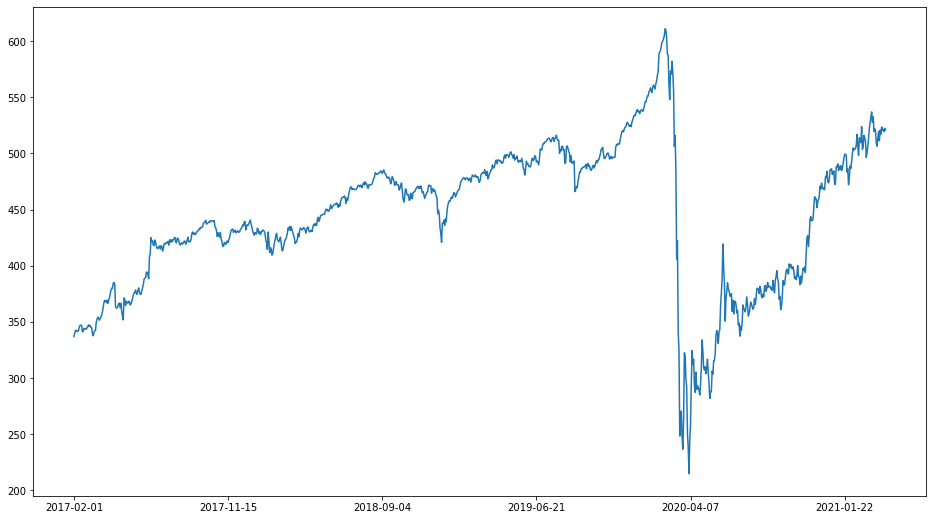

In [25]:
precios[reit.index].sum(axis=1).plot(figsize=(16,9))
plt.show()

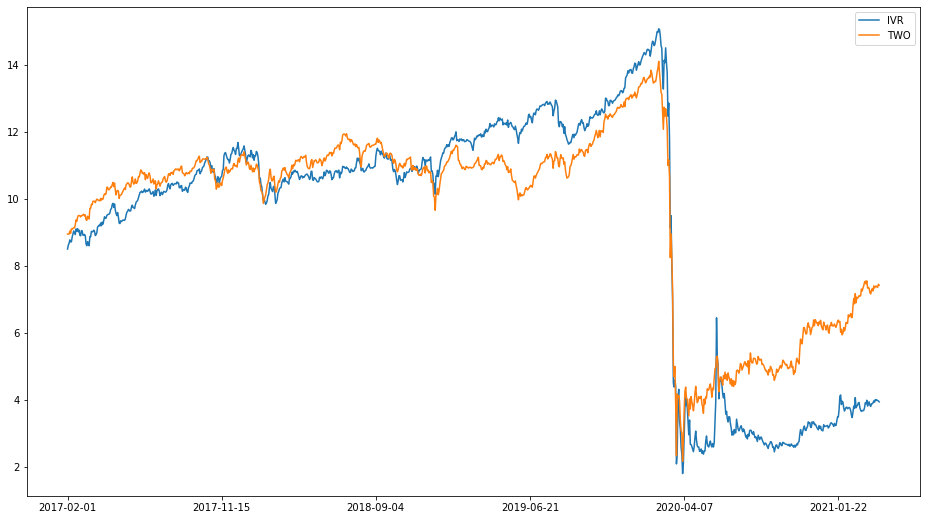

In [26]:
precios[['IVR', 'TWO']].plot(figsize=(16,9))
plt.show()

### Acciones de Dividendos

In [27]:
df[df['MarketCap']>100000].sort_values('Div', ascending = False).head(10)

,$\mu$,Sharpe,feb20,pmax,$\mu_2$,Sharpe2,sd,pmin2,pmax2,Name,...,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,,,,,,,
T,0.05,0.24,35.38,35.83,0.23,0.86,1.05,24.53,30.99,AT&T Inc,...,"214,000.00",0.07,3.18,9.73,1.22,0.12,0.04,0.86,-3.01,1983-11-21
BHP,0.16,0.65,47.04,53.08,0.88,2.36,11.68,30.33,78.98,Bhp Billiton Ltd,...,"114,000.00",0.06,0.00,0.00,2.19,0.00,0.00,0.36,18.53,1980-03-17
TOT,0.05,0.30,43.80,55.47,0.62,1.38,5.28,26.09,49.43,Totalfinaelf S.A.,...,"121,000.00",0.05,1.43,32.38,1.15,0.04,0.02,0.57,-6.05,1991-10-25
IBM,0.02,0.10,143.27,151.12,0.45,1.34,6.77,89.79,136.38,International Business Machines,...,"121,000.00",0.05,8.67,15.56,5.84,0.38,0.05,2.62,7.59,1962-01-02
ABBV,0.23,0.83,89.45,104.34,0.58,2.08,10.85,61.23,112.62,Abbvie Inc,...,"187,000.00",0.05,10.51,10.01,14.31,1.99,0.13,5.92,10.08,2013-01-02
PFE,0.09,0.53,32.64,40.17,0.37,1.31,2.35,25.94,42.10,Pfizer Inc,...,"201,000.00",0.04,2.72,13.20,3.18,0.24,0.09,0.59,22.95,1972-06-01
VZ,0.12,0.68,55.05,58.21,0.20,1.02,2.38,47.32,60.44,Verizon Communications Inc,...,"238,000.00",0.04,4.90,12.04,3.52,0.31,0.07,1.78,13.88,1983-11-21
TD,0.08,0.59,53.97,54.96,0.75,2.26,8.41,31.89,66.15,Toronto Dominion Bank,...,"120,000.00",0.04,4.17,15.91,1.73,0.12,0.01,0.13,22.16,1996-08-30
AZN,0.25,1.14,46.68,48.96,0.31,1.05,3.25,37.74,59.47,Astrazeneca Plc,...,"130,000.00",0.04,2.02,23.97,8.31,0.38,0.08,1.12,12.01,1993-05-12


In [28]:
df.nlargest(10, "Div")

,$\mu$,Sharpe,feb20,pmax,$\mu_2$,Sharpe2,sd,pmin2,pmax2,Name,...,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,,,,,,,
IRCP,-0.27,-0.56,9.02,44.34,0.82,1.17,2.39,3.74,13.25,Irsa Propiedades Ads,...,294.52,0.37,4.33,3.15,0.28,0.02,0.01,0.37,146.40,2003-11-05
AIV,0.13,0.80,4.53,4.53,1.19,2.19,0.91,2.08,6.42,Apartment Investment and Management,...,928.07,0.32,0.16,2.03,1.38,-0.01,0.00,0.80,-3.33,1994-07-22
MAGS,-0.10,-0.27,2.39,4.91,0.92,1.80,1.14,1.56,5.25,Magal Security Syst,...,95.63,0.18,0.04,220.00,1.20,0.01,0.00,NaN,2.64,1993-03-23
TRMD,0.23,0.36,7.16,11.11,0.69,0.77,0.83,5.88,11.26,Torm Plc Cl A,...,679.57,0.18,1.19,7.73,0.67,0.08,0.04,0.73,11.79,2018-02-23
SJT,-0.18,-0.42,2.37,8.33,1.16,1.80,0.66,1.54,4.33,San Juan Basin Royalty Trust,...,195.30,0.16,0.11,37.09,37.02,1.43,1.14,0.00,83.84,1980-10-24
FRO,0.18,0.40,6.76,10.89,0.42,0.68,0.74,5.41,9.46,Frontline Ltd,...,"1,500.48",0.16,2.14,3.58,0.91,0.26,0.11,1.25,33.81,2001-08-06
AM,-0.38,-0.97,4.09,15.07,1.63,2.43,2.01,1.66,9.58,Antero Midstream Corp,...,"4,254.01",0.14,0.91,9.84,1.77,0.17,0.08,1.28,-13.60,2017-05-04
USAC,0.10,0.38,13.06,14.63,1.64,2.20,2.80,3.71,15.76,USA Compression Partners LP,...,"1,492.77",0.14,-0.22,0.00,4.22,0.04,0.01,5.71,-89.07,2013-01-15
ORC,-0.02,-0.08,5.47,6.56,1.19,1.94,0.89,2.04,6.03,Orchid Island Capital Inc,...,568.76,0.13,1.20,5.01,1.22,0.22,0.02,0.00,1.84,2013-02-14


In [29]:
df.loc[['SWKS', 'AVGO', 'TMUS', 'QCOM', 'NVDA']].iloc[:,-15:]

,Name,Industry,Last,SIC Description,Sector,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,
SWKS,Skyworks Solutions,Semi Radio Frequency,188.73,SIC-3674 Semiconductors & Related Devices,Computers and Technology,"31,310.59",0.01,6.83,27.41,7.16,0.27,0.22,0.00,24.28,1984-09-07
AVGO,Broadcom Ltd,Electronics - Semiconductors,485.09,SIC-3674 Semiconductors & Related Devices,Computers and Technology,"198,000.00",0.03,20.08,24.03,8.32,0.38,0.12,1.69,12.39,2009-08-06
TMUS,T-Mobile US,Wireless National,129.03,SIC-4812 Radiotelephone Communications,Utilities,"162,000.00",0.00,4.04,32.18,2.50,0.08,0.03,1.09,4.48,2007-04-19
QCOM,Qualcomm Inc,Wireless Equipment,140.57,SIC-3663 Radio & Tv Broadcasting & Communicati...,Computers and Technology,"159,000.00",0.02,4.51,30.92,21.60,1.05,0.15,2.06,22.09,1991-12-13
NVDA,Nvidia Corp,Semi General,576.00,NaN,Computers and Technology,"355,000.00",0.00,8.14,69.50,20.53,0.35,0.20,0.39,25.98,1999-01-22


In [30]:
df[(df.firstTradeDate > "2015-01-01") & (df.Sharpe > 1)]

,$\mu$,Sharpe,feb20,pmax,$\mu_2$,Sharpe2,sd,pmin2,pmax2,Name,...,MarketCap,Div,BPA,PER,P/B,ROE,ROA,D/E,Profit%,firstTradeDate
Symbol,,,,,,,,,,,,,,,,,,,,,
FRHC,0.42,1.24,16.63,16.63,1.46,3.56,14.99,12.70,60.23,Freedom Holding Corp,...,"3,257.61",0.00,1.56,36.78,14.55,0.54,0.09,0.64,20.38,2018-02-07
SI,1.07,2.76,16.52,16.65,3.29,3.30,48.84,8.25,176.27,Silvergate Capital Corp Cl A,...,"3,688.56",0.00,1.36,103.36,9.62,0.10,0.01,0.05,26.36,2019-11-07
SQ,0.70,1.49,85.70,99.01,2.01,3.06,64.03,40.01,276.57,Square,...,"117,000.00",0.00,0.00,0.00,39.12,0.01,0.00,0.96,2.24,2015-11-19
EVA,0.25,1.22,35.90,35.90,0.82,2.97,7.29,21.14,53.03,Enviva Partners LP,...,"1,917.10",0.07,0.28,170.14,6.78,0.14,0.03,3.31,1.95,2015-04-29
ETSY,0.61,1.20,54.39,72.77,2.05,2.95,54.01,33.03,244.58,Etsy Inc,...,"27,149.70",0.00,2.63,77.57,33.49,0.60,0.18,1.49,20.24,2015-04-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ARCE,0.76,1.54,57.36,57.36,-0.15,-0.29,6.35,24.86,56.68,Arco Platform Ltd Cl A,...,875.42,0.00,0.06,465.17,1.74,0.01,0.00,0.09,1.68,2018-09-26
OYST,2.80,3.32,36.74,36.74,-0.28,-0.43,4.51,17.83,36.36,Oyster Point Pharma Inc,...,544.11,0.00,-2.15,0.00,2.91,-0.38,-0.36,0.00,0.00,2019-11-01
HYMC,0.04,1.27,10.31,10.38,-0.52,-0.66,2.12,3.50,15.82,Hycroft Mining Holding Corp,...,245.59,0.00,-3.88,0.00,7.63,0.00,-0.79,4.47,-282.04,2018-03-12
